[Chapter 3] Distance Metrics

In [547]:
import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal
import scipy.stats as ss
from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt

generate random variables

In [548]:
np.random.seed(0)

# generate linearly correlated random variables
x = np.random.randn(1000)
y = 0.5 * x + 0.1 * np.random.randn(1000)  # add some noise
bins = 10

In [549]:
# discretized into regular grid with a number of partition (bins) per dimension

# joint counts/distribution
cXY = np.histogram2d(x, y, bins)[0] 
print(np.sum(cXY))
cXY

1000.0


array([[  8.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  4.,  16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   9.,  56.,   5.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  18., 110.,  18.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  31., 162.,  24.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  34., 171.,  34.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   1.,  32., 112.,  15.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  16.,  50.,  20.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,  22.,   9.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  13.]])

marginal entropy

In [550]:
# entropy of X: the expected value of surprises, the amount of uncertainty associated with X

# hX = -sum{p(x)*log(p(x))} 
# log(p(x)) measures hows surprising as surprising are characterized by low prob
hX = ss.entropy(np.histogram(x, bins)[0])
print(hX)
# bins = 1, hX = 0 (zero entropy when all prob is concerntrated in a single element)
# bins = 10, hX = 2.301 (entropy closer to max when X is distributed more uniformly)

# check with alternative
cX = np.histogram(x, bins)[0] # count
pX = cX/np.sum(cX)            # prob
hX_alt = -np.sum(pX * np.log(pX + 1e-10))
print(hX_alt)

1.9528011589708985
1.9528011579708984


In [551]:
# entropy of Y
hY = ss.entropy(np.histogram(y, bins)[0])
print(hY)

1.9943498307707825


mutual information

In [552]:
# decrease in uncertainty (or information gain) in X that results from knowing the value Y

# iXY = hX - hX_Y = hX + hY - hXY
# iXX = hX
# iXY = 0 (when X are Y are independent) x = 0
# iXY <= min{hX, hY}

iXY = mutual_info_score(None, None, contingency=cXY) # when y = 0*x + 1*e, iXY = 0.048 -> 0
print(iXY)
# normalized mutual information
iXYn = iXY/min(hX, hY)
print(iXYn)

1.2222238074758958
0.6258823648588945


joint entropy

In [553]:
hXY = hX + hY - iXY
hXY

2.7249271822657857

conditional entropy

In [554]:
# the conditional entropy of X given Y
hX_Y = hXY - hY
# the conditoinal entropy of Y given X
hY_X = hXY - hX

hX_Y, hY_X

(0.7305773514950031, 0.7721260232948872)

variation of information

In [ ]:
# vXY = hXY - iXY = 2*hXY - hX - hY = hX + hY - 2*iXY = hX_Y + hY_X
# the uncertainty we expect in one variable if we are told the value of the other

def varInfo(x, y, bins, norm=False):
    """
    variation of information
    """
    cXY = np.histogram2d(x, y, bins)[0]
    iXY = mutual_info_score(None, None, contingency=cXY)
    hX = ss.entropy(np.histogram(x, bins)[0])
    hY = ss.entropy(np.histogram(y, bins)[0])
    vXY = hX + hY - 2*iXY
    if norm:    # if normalized -> divide vXY by hXY
        hXY = hX + hY -iXY  
        vXY /= hXY # normalized variation information
    return vXY

vXY = varInfo(x, y, bins)
print(vXY)
# check
print(hXY-iXY, hX_Y + hY_X)

1.5027033747898897
1.50270337478989 1.5027033747898904


on discretized continuous random variables（assuming gaussian distribution)

In [574]:
def numBins(nObs, corr=None):
    """
    optimal number of bins for discretization (based on formula)
    Hacine-Gharbi et al. (2012) for marginal entropy
    Hacine-Gharbi and Raiver (2018) for joint entropy
    """
    # univariate case
    if corr is None:
        z = (8 + 324*nObs + 12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b = round(z/6. + 2./(3*z) + 1./3)
    else:
        b = round((2**-.5)*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    
    return int(b)

#-----------------------------------------------------------------------------

def varInfo(x, y, norm=False):
    """
    variation of information for gaussian random variables with optimal number of bins
    """
    bXY = numBins(x.shape[0], corr=np.corrcoef(x, y)[0, 1]) # optimal number of bins
    cXY = np.histogram2d(x, y, bXY)[0]
    iXY = mutual_info_score(None, None, contingency=cXY)
    hX = ss.entropy(np.histogram(x, bXY)[0]) # marginal
    hY = ss.entropy(np.histogram(y, bXY)[0]) # marginal
    vXY = hX + hY - 2*iXY 
    if norm:    # if to normalize -> divide vXY by hXY
        hXY = hX + hY -iXY  
        vXY /= hXY # normalized variation information
    return vXY

#-----------------------------------------------------------------------------

def mutualInfo(x, y, norm=False):
    """"
    mutual information for gaussian random variables with optimal number of bins
    """
    bXY = numBins(x.shape[0], corr=np.corrcoef(x, y)[0, 1]) # optimal number of bins
    cXY = np.histogram2d(x, y, bXY)[0]
    iXY = mutual_info_score(None, None, contingency=cXY)
    if norm: # if to normalize
        hX = ss.entropy(np.histogram(x, bXY)[0]) # marginal
        hY = ss.entropy(np.histogram(y, bXY)[0]) # marginal
        iXY /= min(hX, hY) # normalized mutual information
    return iXY


experimental results

0.006764619108279091 0.001496837406727644


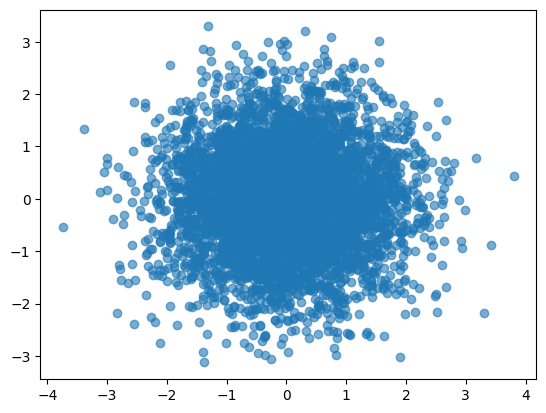

In [ ]:
# no relationship

size, seed = 5000, 0
np.random.seed(seed)
# generate gaussian random variables
x = np.random.normal(size=size)
e = np.random.normal(size=size)
y = 0*x + e # no relationship
nmi = mutualInfo(x, y, True)
corr = np.corrcoef(x, y)[0, 1]
print(nmi, corr) # both correlation and normalized mutual information are approximately zero
# plot
plt.scatter(x, y, alpha=0.6, label='y = 0*x + e')

0.890663507957648 0.9999495557993869


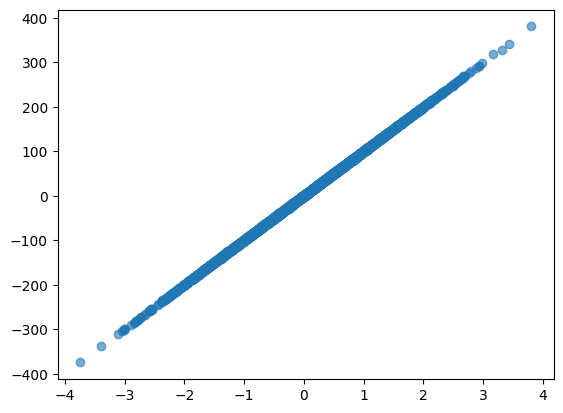

In [573]:
# linear relationship

size, seed = 5000, 0
np.random.seed(seed)
# generate gaussian random variables
x = np.random.normal(size=size)
e = np.random.normal(size=size)
y = 100*x + e 
nmi = mutualInfo(x, y, True)
corr = np.corrcoef(x, y)[0, 1]
print(nmi, corr)
# coef = 100 (strong linear), corr = 1, nmi_n = 0.89 (still not 1 given there's some degree of uncertainty with e)
# coef = 10000 (stronger linear), corr = 1, nmi_n = 0.995

# plot
plt.scatter(x, y, alpha=0.6, label='y = 100*x + e')

0.6438647001258101 -0.00796402292795633


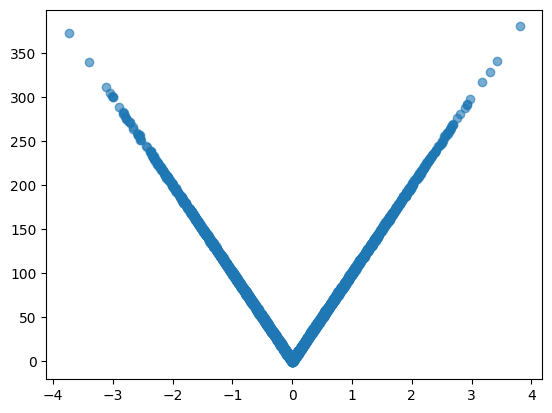

In [ ]:
# nonlinear relatinoship

size, seed = 5000, 0
np.random.seed(seed)
# generate gaussian random variables
x = np.random.normal(size=size)
e = np.random.normal(size=size)
y = 100*np.abs(x) + e 
nmi = mutualInfo(x, y, True)
corr = np.corrcoef(x, y)[0, 1]
print(nmi, corr)
# corr = -0.007 (close to 0) failed to recognize the strong linear relationship between x and y becuase it is nonlinear
# in contract, the normalized mutual information (nmi) is high of 0.644 (not 1, knowing y does not suffice to know x given 2 alternative values of x to know y)
#               recognizing that we can extract a subtantial amount of information from x that is useful to predict y
# coef from 100 to 1000 will not increase the nmi given the main source of uncertainty is not from e

# that's why entropy many ML algo do not impoase a functional form of data, use them in conjunction with entropy-based features
# it allows us to answer questions regarding the unique info contributed by a random variable, without having to make functional assumptions

# plot
plt.scatter(x, y, alpha=0.6, label='y = 100*|x| + e')